# Exploratory Data Analysis (EDA) - Lung Cancer CT Scan Dataset

This notebook explores the chest CT scan dataset used for training a deep learning model
to classify between:
- Normal (No Cancer)
- Adenocarcinoma
- Large-Cell Carcinoma
- Squamous Cell Carcinoma

The goal is to understand the dataset, check class distributions, and visualize sample images
before training.

In [1]:
import os

DATASET_PATH = "../datasets/dataset_4/train"
print("Classes in dataset_1:", sorted(os.listdir(DATASET_PATH)))

Classes in dataset_1: ['adenocarcinoma', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


In [2]:
import os
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
from collections import Counter

sys.path.append(os.path.abspath(".."))

from utils.data_loader import get_datasets

# Paths and hyperparameters
DATA_DIR = "./datasets"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Load combined datasets
train_ds, val_ds, test_ds, class_names = get_datasets(main_dir=DATA_DIR)
print("Unified Classes:", class_names)

# Confirm number of batches
print("Training batches:", len(list(train_ds)))
print("Validation batches:", len(list(val_ds)))
print("Test batches:", len(list(test_ds)))

2025-08-20 22:38:16.407453: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 613 files belonging to 4 classes.
Found 72 files belonging to 4 classes.
Found 315 files belonging to 4 classes.
[INFO] dataset_1 label map: {0: 'Adenocarcinoma', 1: 'Large Cell Carcinoma', 2: 'Normal', 3: 'Squamous Cell Carcinoma'}
Found 1460 files belonging to 6 classes.
Found 142 files belonging to 6 classes.
Found 475 files belonging to 6 classes.
[INFO] dataset_2 label map: {0: 'Benign', 1: 'Malignant', 2: 'Adenocarcinoma', 3: 'Large Cell Carcinoma', 4: 'Normal', 5: 'Squamous Cell Carcinoma'}
Found 612 files belonging to 4 classes.
Found 72 files belonging to 4 classes.
Found 315 files belonging to 4 classes.
[INFO] dataset_3 label map: {0: 'Adenocarcinoma', 1: 'Large Cell Carcinoma', 2: 'Normal', 3: 'Squamous Cell Carcinoma'}
Found 3240 files belonging to 6 classes.
Found 678 files belonging to 5 classes.
Found 680 files belonging to 5 classes.
[INFO] dataset_4 label map: {0: 'Adenocarcinoma', 1: 'Adenocarcinoma', 2: 'Large Cell Carcinoma', 3: 'Large Cell Carcinoma', 4: 'No

## Class Distribution

We check how balanced the dataset is across the four classes.
Imbalanced datasets can affect training and may require techniques like class weighting or data augmentation.

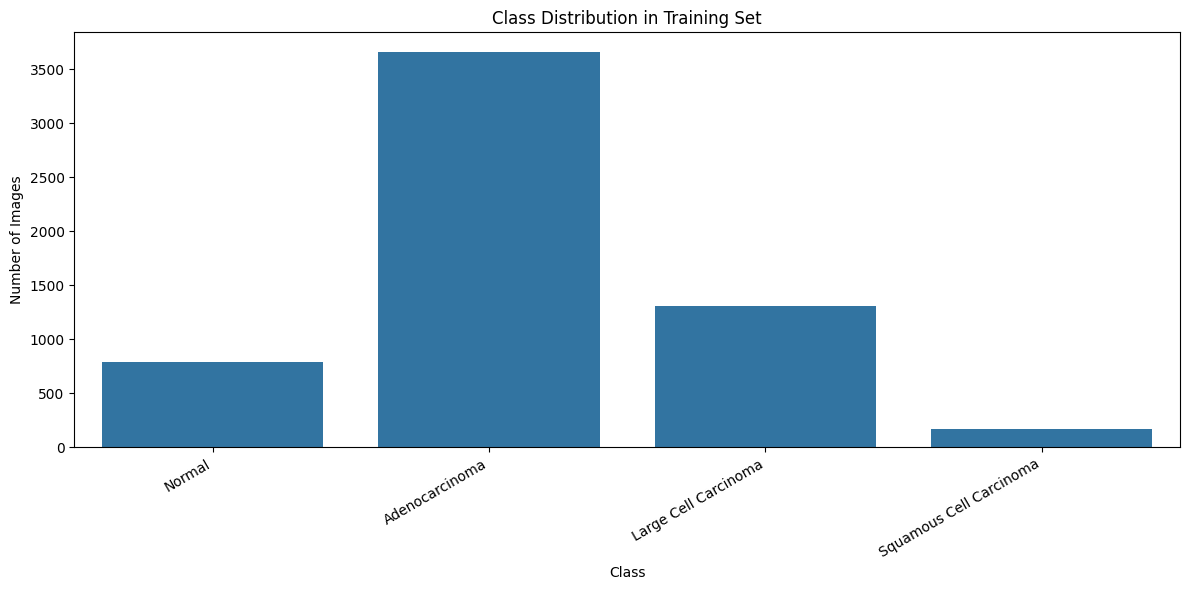

Number of images per class:
Normal: 787
Adenocarcinoma: 3659
Large Cell Carcinoma: 1310
Squamous Cell Carcinoma: 169
Benign: 0
Malignant: 0


In [3]:
class_names = [
    "Normal", "Adenocarcinoma", "Large Cell Carcinoma", 
    "Squamous Cell Carcinoma", "Benign", "Malignant"
]

label_counts = Counter()

for _, label in train_ds:
    label_value = label.numpy()
    label_counts[label_value] += 1

# --- Plotting and Printing ---

sorted_keys = sorted(label_counts.keys())

# Plot distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=[class_names[k] for k in sorted_keys], y=[label_counts[k] for k in sorted_keys])
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.xticks(rotation=30, ha='right') 
plt.tight_layout() 
plt.show()

print("Number of images per class:")
for i, class_name in enumerate(class_names):
    count = label_counts.get(i, 0)
    print(f"{class_name}: {count}")

## Sample Images per Class

Let’s visualize some sample CT scan images from each class to get a sense of what the data looks like.

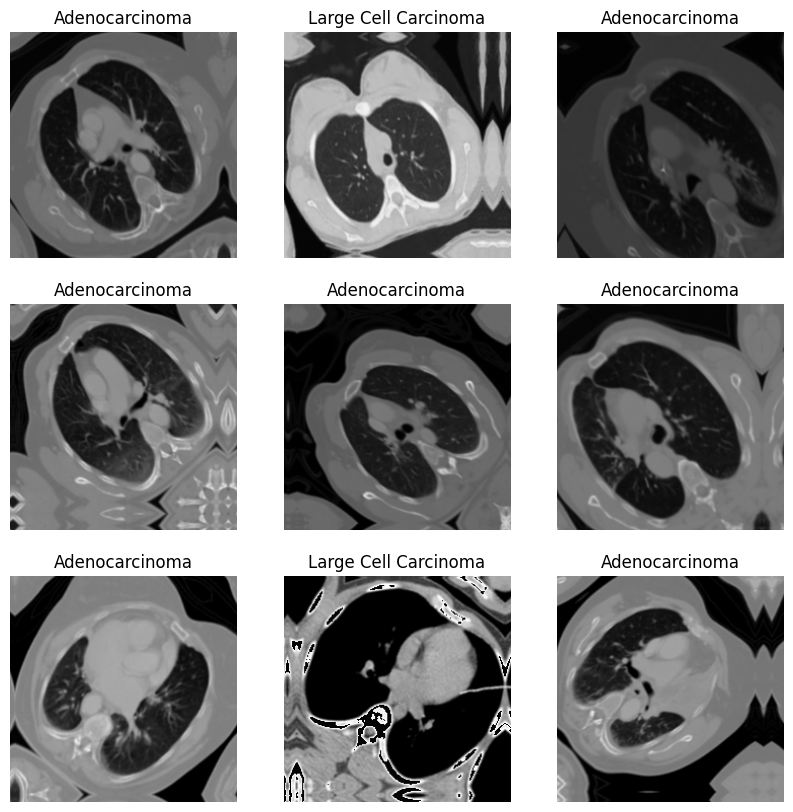

In [4]:
def denormalize(img):
    """Convert normalized image back to 0-255 for display."""
    img_np = np.array(img)
    return (img_np * 255).astype(np.uint8)

plt.figure(figsize=(10, 10))

for images, labels in train_ds.batch(9).take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(denormalize(images[i].numpy()))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")

plt.show()

## Image Shapes

We check the shape of the images and confirm the preprocessing step (resizing).


In [5]:
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (224, 224, 3)
Label batch shape: ()


## Pixel Value Range

Since deep learning models perform better when inputs are normalized,
we confirm the pixel value scaling.

In [6]:
for images, labels in train_ds.take(1):
    print("Min pixel value:", tf.reduce_min(images).numpy())
    print("Max pixel value:", tf.reduce_max(images).numpy())

Min pixel value: 0.009788394
Max pixel value: 0.8908663


## Data Augmentation 

If we plan to use augmentation, let’s preview some transformations.


2025-08-20 22:42:30.770221: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: Attempting to slice scalar input.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} Attempting to slice scalar input. [Op:StridedSlice] name: strided_slice/

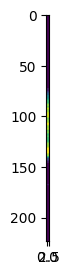

In [7]:
# Define augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

# Show augmented images
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        augmented = data_augmentation(tf.expand_dims(images[i], axis=0))
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(denormalize(augmented[0].numpy()))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    break
plt.show()
